<a href="https://colab.research.google.com/github/kursatkara/MAE_5020_Spring_2025/blob/master/MINST_Digit_Recognition_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MINST - Digit Recognition - CNN

Change the runtime to T4 GPU
On the Menu, go to the Runtime->Change Runtime Type->T4 GPU

## Importing Required Libraries

In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms


## Preparing the MNIST Dataset

In [18]:
# Define a transform: convert the images to tensors and normalize them
transform = transforms.Compose([
    transforms.ToTensor(),  # convert images to Tensor
    transforms.Normalize((0.1307,), (0.3081,))  # normalize using MNIST mean and std
])

# Download and load the training and test datasets
train_dataset = datasets.MNIST(root='/content/sample_data/', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='/content/sample_data/', train=False, download=True, transform=transform)

# DataLoaders for batching and shuffling the dataset
batch_size = 64
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


100%|██████████| 9.91M/9.91M [00:00<00:00, 16.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 460kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.43MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.59MB/s]


## Building the Neural Network Model

In [19]:
# Define your model architecture, which must be exactly the same as during training

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Convolutional layers: input channels = 1 (grayscale), output channels: 32 and 64
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1)
        # Dropout layers to help prevent overfitting
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        # Fully connected layers:
        # The output size after two conv layers and a max pooling becomes 9216
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # First convolutional block
        x = self.conv1(x)
        x = nn.ReLU()(x)
        # Second convolutional block
        x = self.conv2(x)
        x = nn.ReLU()(x)
        # Max pooling to down-sample the feature maps
        x = nn.MaxPool2d(2)(x)
        # Apply dropout
        x = self.dropout1(x)
        # Flatten the tensor
        x = torch.flatten(x, 1)
        # Fully connected layers with ReLU and dropout
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.dropout2(x)
        # Final output layer with LogSoftmax activation
        x = self.fc2(x)
        output = nn.LogSoftmax(dim=1)(x)
        return output

## Configuring the Training

### Device Setup:

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [21]:
print(device)

cuda


### Checking the Pre-Trained Model:

In [30]:
import os

# Create an instance of the model
#model = Net()
model = Net().to(device)

# Define the model path
model_path = '/content/sample_data/cnn_mnist_model.pth'

# Check if the model file exists
if os.path.exists(model_path):
    print(f"Pre-trained model found at {model_path}. Loading the model...")
    model.load_state_dict(torch.load(model_path))
    pre_trained = True
    print("Model loaded successfully.")
else:
    pre_trained = False
    print(f"Model file not found at {model_path}. Continuing with the newly initialized model.")


Pre-trained model found at /content/sample_data/cnn_mnist_model.pth. Loading the model...
Model loaded successfully.


### Training the Model

In [31]:
if pre_trained:
    print("Pre-trained model found. Skipping training.")
else:

    model = Net().to(device)
    criterion = nn.NLLLoss()            # negative log likelihood loss (compatible with LogSoftmax)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    n_epochs = 5  # You can adjust the number of epochs as needed
    print(f"Training the model for {n_epochs} epochs...")
    for epoch in range(n_epochs):
        model.train()  # Set the model to training mode
        for batch_idx, (data, target) in enumerate(train_loader):
            # Move data to the device (GPU or CPU)
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()         # Clear previous gradients
            output = model(data)          # Forward pass
            loss = criterion(output, target)  # Compute loss
            loss.backward()               # Backpropagation
            optimizer.step()              # Update the weights

            if batch_idx % 100 == 0:
                print(f'Epoch: {epoch+1} [{batch_idx * len(data)}/{len(train_loader.dataset)}]  Loss: {loss.item():.6f}')


Pre-trained model found. Skipping training.


## Evaluating the Model

In [32]:
model.eval()  # Set the model to evaluation mode
test_loss = 0
correct = 0

with torch.no_grad():  # Disable gradient computation for evaluation
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += criterion(output, target).item()  # Sum batch losses
        pred = output.argmax(dim=1, keepdim=True)      # Get the index of the highest log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

test_loss /= len(test_loader.dataset)
accuracy = 100. * correct / len(test_loader.dataset)

print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)')



Test set: Average loss: 0.0005, Accuracy: 9907/10000 (99.07%)


## Saving the Model

In [33]:
# Save the model's state dictionary to a file
if not pre_trained:
    print("Pre-trained model not found. Saving the model.")
    model_path = '/content/sample_data/cnn_mnist_model.pth'
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")
else:
    print("Pre-trained model found.")


Pre-trained model found.


# Visual Results

## Visualizing a Batch of Training Data

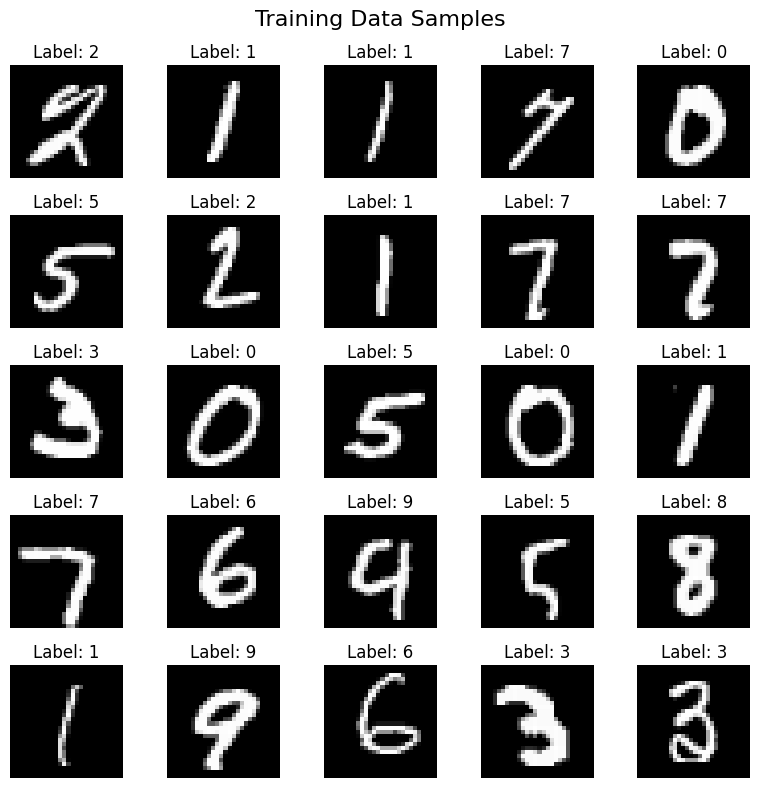

In [37]:
import matplotlib.pyplot as plt
import torch

# Get a batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Create a grid of 25 images (5 x 5)
fig, axes = plt.subplots(5, 5, figsize=(8, 8))
fig.suptitle('Training Data Samples', fontsize=16)

for i, ax in enumerate(axes.flat):
    if i < len(images):
        # Unnormalize the image: image * std + mean
        img = images[i] * 0.3081 + 0.1307
        ax.imshow(img.squeeze(), cmap='gray')
        ax.set_title(f'Label: {labels[i].item()}')
        ax.axis('off')

plt.tight_layout()
plt.show()


## Visualizing a Batch of Testing Data

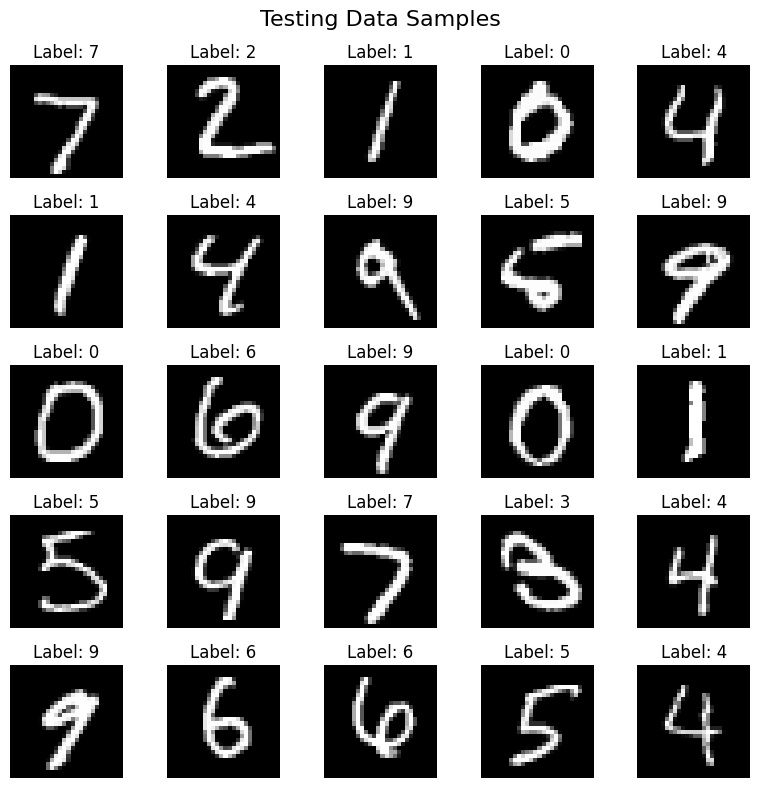

In [38]:
import matplotlib.pyplot as plt

# Get a batch of testing images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Create a grid of 25 images (5 x 5)
fig, axes = plt.subplots(5, 5, figsize=(8, 8))
fig.suptitle('Testing Data Samples', fontsize=16)

for i, ax in enumerate(axes.flat):
    if i < len(images):
        # Unnormalize the image: image * std + mean
        img = images[i] * 0.3081 + 0.1307
        ax.imshow(img.squeeze(), cmap='gray')
        ax.set_title(f'Label: {labels[i].item()}')
        ax.axis('off')

plt.tight_layout()
plt.show()


## Visualizing Evaluation Results with Prediction Status

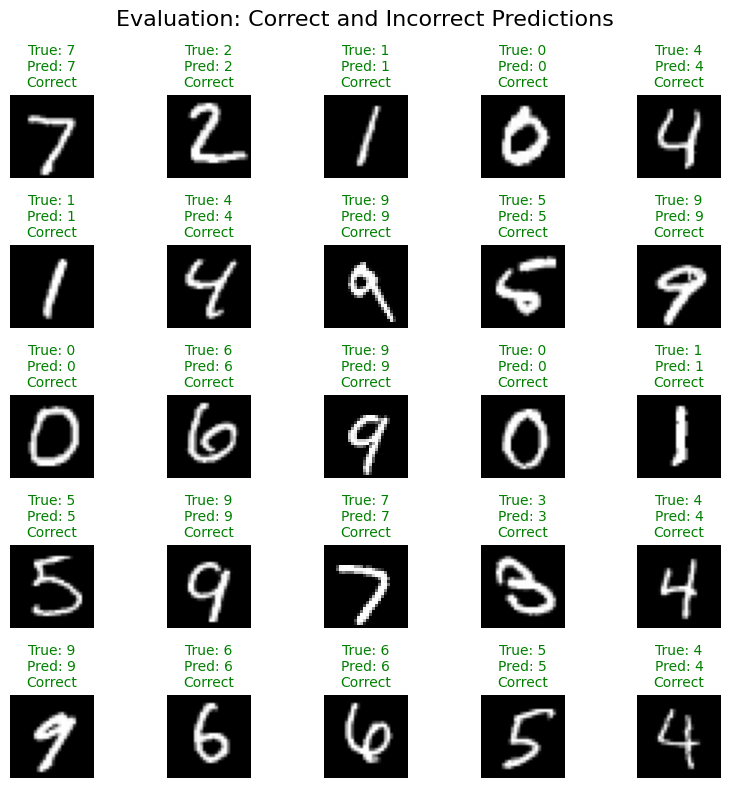

In [41]:
import matplotlib.pyplot as plt
import torch

# Ensure the model is in evaluation mode
model.eval()

# Grab a batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Move data to the appropriate device (if using GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
images = images.to(device)
labels = labels.to(device)

# Get model predictions
with torch.no_grad():
    outputs = model(images)
    preds = outputs.argmax(dim=1)

# Bring tensors back to CPU for plotting
images = images.cpu()
labels = labels.cpu()
preds = preds.cpu()

# Create a grid of 25 images (5 x 5) for evaluation results
fig, axes = plt.subplots(5, 5, figsize=(8, 8))
fig.suptitle('Evaluation: Correct and Incorrect Predictions', fontsize=16)

for i, ax in enumerate(axes.flat):
    if i < len(images):
        # Unnormalize the image for visualization
        img = images[i] * 0.3081 + 0.1307
        true_label = labels[i].item()
        pred_label = preds[i].item()
        result = "Correct" if true_label == pred_label else "Incorrect"
        title_color = 'green' if result == "Correct" else 'red'

        ax.imshow(img.squeeze(), cmap='gray')
        ax.set_title(f"True: {true_label}\nPred: {pred_label}\n{result}", color=title_color, fontsize=10)
        ax.axis('off')

plt.tight_layout()
plt.show()


## Visualizing Evaluation Results with Failed Predictions

Total number of misclassified images: 93
Showing a random sample of 25 misclassified images.


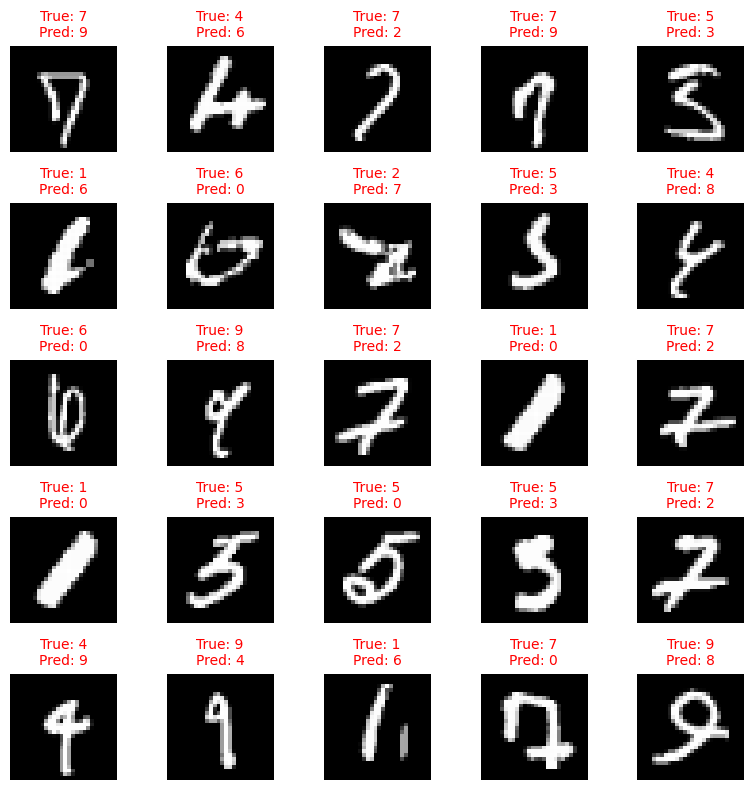

In [46]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# Set the model to evaluation mode
model.eval()

# Prepare lists to collect misclassified images, their true labels, and predictions
misclassified_images = []
misclassified_true_labels = []
misclassified_pred_labels = []

# Ensure data is on the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Iterate through all test batches
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        preds = outputs.argmax(dim=1)
        # Create a boolean mask for misclassified samples
        incorrect_mask = preds != target

        if incorrect_mask.any():
            # Collect misclassified samples from this batch
            misclassified_images.append(data[incorrect_mask].cpu())
            misclassified_true_labels.append(target[incorrect_mask].cpu())
            misclassified_pred_labels.append(preds[incorrect_mask].cpu())

# Combine all batches into single tensors
if misclassified_images:
    misclassified_images = torch.cat(misclassified_images, dim=0)
    misclassified_true_labels = torch.cat(misclassified_true_labels, dim=0)
    misclassified_pred_labels = torch.cat(misclassified_pred_labels, dim=0)

    total_errors = misclassified_images.shape[0]
    print(f"Total number of misclassified images: {total_errors}")

    # If there are many misclassified images, show a random sample (e.g. 25)
    max_images = 25
    if total_errors > max_images:
        indices = torch.randperm(total_errors)[:max_images]
        misclassified_images = misclassified_images[indices]
        misclassified_true_labels = misclassified_true_labels[indices]
        misclassified_pred_labels = misclassified_pred_labels[indices]
        print(f"Showing a random sample of {max_images} misclassified images.")
    else:
        print(f"Showing all {total_errors} misclassified images.")

    # Determine grid size for visualization
    num_images = misclassified_images.shape[0]
    grid_size = int(np.ceil(np.sqrt(num_images)))

    fig, axes = plt.subplots(grid_size, grid_size, figsize=(8, 8))
    axes = axes.flatten()  # simplify iteration over axes

    for i in range(num_images):
        ax = axes[i]
        # Unnormalize the image to bring it back to displayable format:
        # (MNIST normalization uses mean=0.1307, std=0.3081)
        img = misclassified_images[i] * 0.3081 + 0.1307
        true_label = misclassified_true_labels[i].item()
        pred_label = misclassified_pred_labels[i].item()

        ax.imshow(img.squeeze(), cmap='gray')
        ax.set_title(f"True: {true_label}\nPred: {pred_label}", fontsize=10, color='red')
        ax.axis('off')

    # Hide any unused subplots
    for j in range(num_images, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No misclassified images were found in the test dataset.")
